In [16]:
from scipy.stats import multivariate_normal
import re
import numpy as np
import matplotlib.pyplot as plt

In [39]:
def read_file(filename):
    with open(filename, "r") as f:
        data = f.read()[:-2]

    data = re.sub("^( )*","",data)
    data = re.sub("( )*\n( )*","\n",data)
    data = re.sub("( )+"," ",data)
    data_l = data.split("\n")
    for i in range(len(data_l)):
        data_l[i] = data_l[i].split(" ")
        data_l[i] = [ float(j) for j in data_l[i] ]
    data_l = np.array(data_l)
    return data_l

def random_init_gmm(data, K):
    low, high = np.min(data, axis=0), np.max(data, axis=0)
    centers = []
    sigmas = []
    pis = np.random.rand(K,1)
    pis = pis/np.sum(pis)
    for i in range(K):
        centers.append(np.random.uniform(low, high))
        sigmas.append(np.cov(data.T))

    return np.array(centers), np.array(sigmas), pis

def init_gmm(data, centers, preds):
    centers = []
    sigmas = []
    pis = np.random.rand(K,1)
    pis = pis/np.sum(pis)
    for i in range(centers.shape[0]):
        ix = np.where(preds==i)
        centers.append(centers[i])
        sigmas.append(np.cov(data[ix,:].T))

    return np.array(centers), np.array(sigmas), pis

def get_pdfs(mus, sigmas):
    pdfs = []
    for i in range(len(mus)):
        pdfs.append(multivariate_normal(mus[i], sigmas[i]).pdf)
    return pdfs

def get_piN(data, pdfs, pis, K):
    N = np.zeros((1500, K)) #*
    for i in range(K):
        N[:,i] = np.apply_along_axis(pdfs[i],1,data)
    return N*pis.T

def get_resp(piN):
    s = np.sum(piN, axis=1, keepdims=True)
    resp = piN/s
    return resp

def m_step(data, resp):
    n_k = np.sum(resp, axis=0)
    
    new_mus = np.sum(data[:,np.newaxis] * resp[:,:,np.newaxis], axis=0) / n_k[:,np.newaxis]
     
    diff = (data[:,np.newaxis] - new_mus)
    x = resp[:,:,np.newaxis,np.newaxis]*(diff.reshape(1500,3,2,1)*diff.reshape(1500,3,1,2))
    new_sigmas = np.sum(x,axis=0)/n_k[:,np.newaxis,np.newaxis]
    
    new_pis = n_k/data.shape[0]
    
    return new_mus, new_sigmas, new_pis

def loglikelihood(piN):
    x = np.sum(piN, axis = 1)
    x = np.sum(np.log(x))
    return -x/piN.shape[0]

In [57]:
data = read_file("Dataset_2.txt")
K=3
mus, sigmas, pis = init_gmm(data, K)
pdfs = get_pdfs(mus, sigmas)
piN = get_piN(data, pdfs, pis, K)
prev = loglikelihood(piN)
print("Initial Avg. LogLoss:",str(prev))

i=0
while True:
    resp = get_resp(piN)
    mus, sigmas, pis = m_step(data, resp)
    pdfs = get_pdfs(mus, sigmas)
    piN = get_piN(data, pdfs, pis, K)
    x = loglikelihood(piN)
    print("Iteration "+str(i+1)+" Avg. LogLoss: "+str(x))
    if abs(prev-x)<10**-5:
        break
    prev = x
    i+=1
    
resp = get_resp(piN)

(2, 2)
Initial Avg. LogLoss: 4.66678260243297
Iteration 1 Avg. LogLoss: 3.0203059037654536
Iteration 2 Avg. LogLoss: 2.9746941928718154
Iteration 3 Avg. LogLoss: 2.9324853158433335
Iteration 4 Avg. LogLoss: 2.8884368161721596
Iteration 5 Avg. LogLoss: 2.839378276761057
Iteration 6 Avg. LogLoss: 2.7853391374215875
Iteration 7 Avg. LogLoss: 2.7290228386609003
Iteration 8 Avg. LogLoss: 2.6762727066710132
Iteration 9 Avg. LogLoss: 2.639925210858778
Iteration 10 Avg. LogLoss: 2.6246221566290577
Iteration 11 Avg. LogLoss: 2.6200912347523304
Iteration 12 Avg. LogLoss: 2.618824148839563
Iteration 13 Avg. LogLoss: 2.6184402206417836
Iteration 14 Avg. LogLoss: 2.618314011861858
Iteration 15 Avg. LogLoss: 2.6182698677795404
Iteration 16 Avg. LogLoss: 2.618253606656692
Iteration 17 Avg. LogLoss: 2.618247335526369


In [58]:
cluster_colors = np.random.uniform(size=(K,3))
colors = resp.dot(cluster_colors)

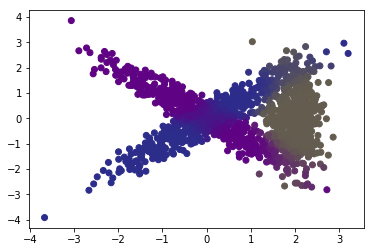

In [59]:
plt.scatter(data[:,0], data[:,1], c=colors)
plt.show()